In [1]:
import tensorflow as tf
import numpy as np
import math
import scipy as sp
import scipy.linalg
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
import utils as ut
rcParams.update({'figure.autolayout':True})
%matplotlib inline

#we are not using biases at present -- all bias related stuff commented out
#useBias = False
#fixedBaseRateBiases = True # only relevant if useBias = True

onehot = False
deep = False
usemodes = False
newitem = 'SparrowHawk'
firstepochs = 0
AddSpHk = 1
DoFits = 0

fig_prefix = "one_hot_" if onehot else "auto_associator_"
if firstepochs > 0: 
    fig_prefix += "frozen_%i_" % firstepochs

lr = .001
szero = .0001
wr = np.sqrt(szero)
vissize = 34
numpats = 10
ndims = 10
hidsize = 32 #currently must equal ndims when initializing with ndims modes
insize = numpats if onehot == True else vissize
maxepochs = 5000
testinterval = 20 # must divide maxepochs and firstepochs
if deep:
    lr = .02
    maxepochs = 50000
    testinterval = 200 # must divide maxepochs
ntests = maxepochs//testinterval + 1 # test at 0 and at maxepochs
sseval = np.zeros(ntests,dtype=np.float32)
stepcount = np.zeros(ntests,dtype=np.float32)
outvec = np.zeros((ntests,numpats,vissize),dtype=np.float32)
hidvec = np.zeros((ntests,numpats,hidsize),dtype=np.float32)
dstrengths = np.zeros((ntests,ndims),dtype=np.float32)
dstrmath = np.zeros((ntests,ndims),dtype=np.float32)
dstrmath9= np.zeros((ntests,ndims),dtype=np.float32)
onesmask = np.ones((numpats,vissize),dtype=np.float32)
wtmask = np.ones((numpats,vissize),dtype=np.float32)
wvec=np.ones(8,dtype=np.float32)
mod_mu = np.zeros((insize,hidsize),dtype=np.float32)
mod_mv = np.zeros((hidsize,vissize),dtype=np.float32)

In [2]:
All8 = np.loadtxt('AllEightB.txt',dtype=np.float32)
All8In = All8
if onehot == True: 
    All8In = np.eye(10)
    All8In[8:9, :] = 0
mu,ms,mv = sp.linalg.svd(All8,full_matrices=False,lapack_driver='gesdd')
dcomp = np.zeros((8,8,34),dtype=np.float32)
for i in np.arange(8):
     dcomp[i,:,:] = ms[i]*np.outer(mu[0:8,i],mv[i,:])
#wtmask8o = np.ones((numpats,vissize),dtype=np.float32)
#wtmask8o[8:10,:] = 0

if newitem == 'SparrowHawk':
    AllPlsPng = np.loadtxt('EightBPlusSpHk.txt',dtype=np.float32)
elif newitem == 'Falcon':
    AllPlsPng = np.loadtxt('EightBPlusFalcon.txt',dtype=np.float32)
AllPlsPngIn = AllPlsPng
if onehot == True:
    AllPlsPngIn = np.eye(10)
    AllPlsPngIn[9, :] = 0
mu9,ms9,mv9 = sp.linalg.svd(AllPlsPng,full_matrices=False,lapack_driver='gesdd')
dcomp9 = np.zeros((9,9,34),dtype=np.float32)
for i in np.arange(9):
     dcomp9[i,:,:] = ms9[i]*np.outer(mu9[0:9,i],mv9[i,:])

In [3]:
if usemodes == True:
    mod_mv[0:8,:] = mv[0:8,:]
    mod_mu[:,0:8] = mu[:,0:8]
    if newitem == 'SparrowHawk':
        mod_mv[8,:] = mv9[6,:]
        mod_mu[:,8] = mu9[:,6]
else:
    mod_mv[:,:] = np.random.randn(hidsize,vissize)/np.sqrt(vissize) # sqrt -> modes norm 1
    mod_mu[:,:] = np.random.randn(insize,hidsize)/np.sqrt(insize)

In [4]:
sess = tf.Session()
wi = tf.get_variable("wi",initializer = 
                     tf.constant((np.sqrt(szero) * mod_mu).astype(np.float32)))
wo = tf.get_variable("wo",initializer = 
                     tf.constant((np.sqrt(szero) * mod_mv).astype(np.float32)))

# the following has not been adjusted to use normalized modes!
if deep:
    wi1 = tf.get_variable("wi1",[hidsize,hidsize],initializer =
                         tf.random_uniform_initializer(minval=-wr,maxval = wr))
    wi2 = tf.get_variable("wi2",[hidsize,hidsize],initializer =
                         tf.random_uniform_initializer(minval=-wr,maxval = wr))

x = tf.placeholder(tf.float32,shape=[numpats,insize])
t = tf.placeholder(tf.float32,shape=[numpats,vissize])
m = tf.placeholder(tf.float32,shape=[numpats,vissize])
h = tf.matmul(x,wi)
if deep:
    h1 = tf.matmul(h,wi1)
    h2 = tf.matmul(h1,wi2)
    y = tf.matmul(h2,wo)
else:
    y = tf.matmul(h,wo)
    
loss = tf.reduce_sum(tf.multiply(m,tf.squared_difference(t,y)))
optimizer = tf.train.GradientDescentOptimizer(lr)
train_op = optimizer.minimize(loss)
train_wionly = optimizer.minimize(loss,var_list = [wi])
saver = tf.train.Saver()
tf.global_variables_initializer().run(session=sess)
fetches = loss,y,h

def eval(bgstep,stp,inpats,targpats):
    sse, out, hid = sess.run(fetches,
                             feed_dict = {x: inpats, t: targpats, m: onesmask})
    stepcount[bgstep] = stp; sseval[bgstep] = sse
    hidvec[bgstep,:,:] = hid; outvec[bgstep,:,:] = out
    us,ss,vs = sp.linalg.svd(out,full_matrices=False,lapack_driver='gesdd')
    dstrengths[bgstep,:]=ss
    return(sse)


In [5]:
bigstep = 0; step = 0;
sse = eval(0,0,All8In,All8)
print(step,sse)
bigstep+=1

# train on 8 animals
for step in range(maxepochs+1):
    _, sse = sess.run([train_op, loss],feed_dict = {x: All8In, t: All8, m: wtmask})
    if step%testinterval==0 and step > 0:
        sse = eval(bigstep,step,All8In,All8)
        bigstep+=1

print(step,sse)
# save training results
save_path = saver.save(sess,"./EightThingsData/Model.ckpt")
wastetime = 0
for i in range(1000000):
    wastetime = wastetime+1
lrnresults = {"stepcount" : stepcount, "sseval" : sseval,"hidvec" : hidvec,
           "outvec" : outvec, "dstregths" : dstrengths}
pickle.dump(lrnresults, open("./EightThingsData/lrnresults.pkl","wb"))

(0, 63.998211)
(5000, 2.2551539e-08)


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


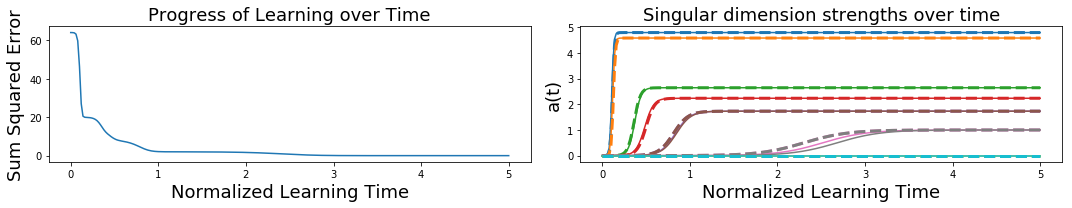

In [6]:
tau = 1/lr; scalefactor = 2
if onehot == True: spow = 1
else: spow = 2

mbstep = 0 
for step in range(0,maxepochs+1,testinterval):
    expfac = np.exp(-2*np.power(ms[0:8],spow)*scalefactor*step/tau)
    dstrmath[mbstep,0:8] = np.divide(ms[0:8],(1+expfac*((ms[0:8]/szero)-1)))
    mbstep+=1
    
mbstep=0  
for step in range(0,maxepochs+1,testinterval):
    expfac = np.exp(-2*np.power(ms9[0:9],spow)*scalefactor*step/tau)
    dstrmath9[mbstep,0:9] = np.divide(ms9[0:9],(1+expfac*((ms9[0:9]/szero)-1)))
    mbstep+=1

def lrncurves():
    fig, ax = plt.subplots(1,2,sharex=True,figsize=(15,3))
    #fig.tight_layout()
    ax[0].plot(stepcount*lr,sseval)
    ax[1].plot(stepcount*lr,dstrengths)
    ax[1].plot(stepcount*lr,dstrmath,linestyle='--',linewidth=3)
    ax[0].set_title('Progress of Learning over Time',fontsize=18)
    ax[1].set_title('Singular dimension strengths over time',fontsize=18)
    ax[0].set_ylabel('Sum Squared Error',fontsize=18)
    ax[0].set_xlabel('Normalized Learning Time',fontsize=18)
    ax[1].set_ylabel('a(t)',fontsize=18)
    ax[1].set_xlabel('Normalized Learning Time',fontsize=18)
    #plt.show()
    #plt.gcf().subplots_adjust(bottom=.3)
    plt.savefig(fig_prefix + 'LearnCurves.eps')

lrncurves()

In [7]:
if deep: maxepochs = 100000
nc = 4
ntests = maxepochs//testinterval + 1 # test at 0 and at maxepochs
sseval3 = np.zeros((nc,ntests),dtype=np.float32)
stepcount3 = np.zeros((nc,ntests),dtype=np.float32)
outvec3 = np.zeros((nc,ntests,numpats,vissize),dtype=np.float32)
errvec3 = np.zeros((nc,ntests,numpats,vissize),dtype=np.float32)
hidvec3 = np.zeros((nc,ntests,numpats,hidsize),dtype=np.float32)
vvec3 = np.zeros((nc,ntests,numpats,vissize),dtype=np.float32)
dstrengths3 = np.zeros((nc,ntests,ndims),dtype=np.float32)
cname = np.chararray(nc,25)

In [8]:
def eval3(bgstep,stp,data,xdata,cond):
    sse, out, hid = sess.run(fetches,feed_dict = {x: xdata, t: data, m: onesmask})
    stepcount3[cond,bgstep] = stp; sseval3[cond,bgstep] = sse
    hidvec3[cond,bgstep,:,:] = hid; outvec3[cond,bgstep,:,:] = out
    errvec3[cond,bgstep,:,:] = np.square(data-out)
    us,ss,vs = sp.linalg.svd(out,full_matrices=False,lapack_driver='gesdd')
    dstrengths3[cond,bgstep,:]=ss
    #if bgstep==0: print(us)
    usf, vsf = ut.fixuv(us,ss,vs)
    #if bgstep==0: print(usf)
    vvec3[cond,bgstep,:,:]=vsf
    return(sse)

def TrainMore(Data,cond,random):
    saver.restore(sess,"./EightThingsData/Model.ckpt")
    mask = wtmask; xData = Data
    if onehot == True: xData = AllPlsPngIn
    bigstep = 0; step = 0;
    sse = eval3(0,0,AllPlsPng,AllPlsPngIn,cond)
    bigstep+=1
    print(cond,step,sse)
    if firstepochs:
        startfull = firstepochs+1 #first epoch after first epochs
        for step in range(firstepochs+1):
            if random == True: mask[0:8,:] = ut.replaysample(8,vissize,wvec)
            _, sse = sess.run([train_wionly, loss],feed_dict = {x: xData, t: Data, m: mask})
            if step%testinterval==0 and step > 0:
                sse = eval3(bigstep,step,AllPlsPng,AllPlsPngIn,cond)
                bigstep+=1
    else:
        startfull = 0 # first epoch number if firstepochs == 0
    for step in range(startfull,maxepochs+1):
        if random == True: mask[0:8,:] = ut.replaysample(8,vissize,wvec)
        _, sse = sess.run([train_op, loss],feed_dict = {x: xData, t: Data, m: mask})
        if step%testinterval==0 and step > 0:
            sse = eval3(bigstep,step,AllPlsPng,AllPlsPngIn,cond)
            bigstep+=1
    print(cond,step,sse)

# Example code for stochastic simulations:
# wtmask[0:8,:] = 1; 
# wvec[0:8] = 1; TrainMore(AllPlsPng,0,True)
# wvec[0:2] = 1; wvec[2:4] = .1; wvec[4:8] = 0; TrainMore(AllPlsPng,1,True)

wvec[0:8] = 1; 

if AddSpHk:
    wtmask[0:8,:] = 1; TrainMore(AllPlsPng,0,False); 
    wtmask[0:2,:] = 1; wtmask[2:4,:] = 0.2; wtmask[4:8,:] = 0.0; TrainMore(AllPlsPng,1,False)
    wtmask[0:8,:] = 0.3; TrainMore(AllPlsPng,2,False)
    wtmask[0:8,:] = 0.0; TrainMore(AllPlsPng,3,False)

# pngresults = {"stepcount3" : stepcount3, "sseval3" : sseval3,"hidvec3" : hidvec3,
#            "outvec3" : outvec3, "errvec3" : errvec3, "dstregths3" : dstrengths3}
# pickle.dump(pngresults, open("./EightThingsData/pngresults.pkl","wb"))

INFO:tensorflow:Restoring parameters from ./EightThingsData/Model.ckpt
(0, 0, 2.453454)
(0, 5000, 2.7896288e-10)
INFO:tensorflow:Restoring parameters from ./EightThingsData/Model.ckpt
(1, 0, 2.453454)
(1, 5000, 0.009185046)
INFO:tensorflow:Restoring parameters from ./EightThingsData/Model.ckpt
(2, 0, 2.453454)
(2, 5000, 2.1248227e-06)
INFO:tensorflow:Restoring parameters from ./EightThingsData/Model.ckpt
(3, 0, 2.453454)
(3, 5000, 7.0945225)


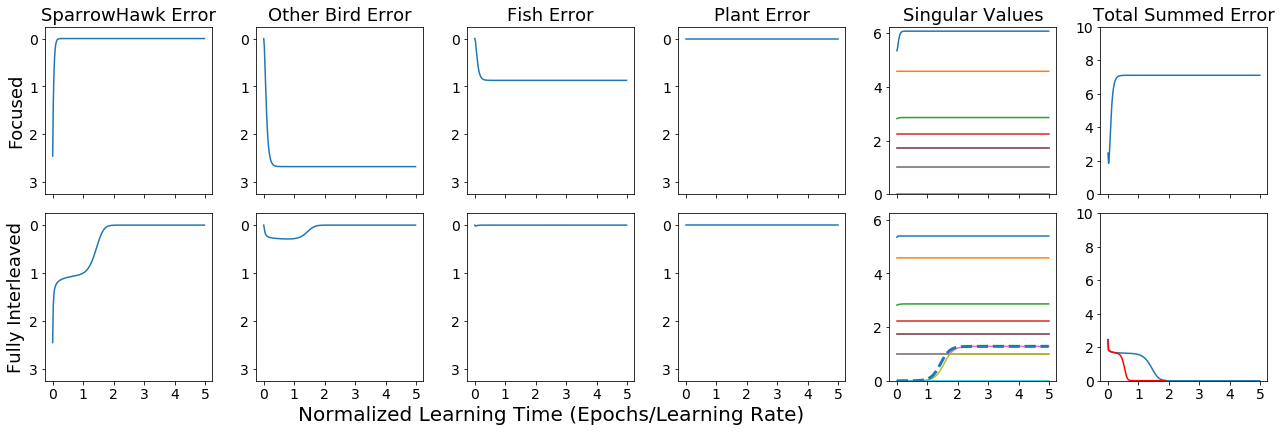

In [9]:
def pnglrnint():
    rcParams.update({'figure.autolayout':False})

    FocusedVsFull = True #if False, we compare Full vs SWIL and Control
    if FocusedVsFull: ar = 2; ix = [3,0]
    else: ar = 3; ix = [0,1,2]
    fig, ax = plt.subplots(ar,6,sharex=True,figsize=(18,ar*3))
    ssmax = 10 #if onehot: ssmax = 10; else: ssmax = 4
    fig.tight_layout()
    #fig.suptitle('Overall Title') -- doesn't fit
    ax[0,0].set_title('SparrowHawk Error',fontsize=18);ax[0,1].set_title('Other Bird Error',fontsize=18)
    ax[0,2].set_title('Fish Error',fontsize=18);
    ax[0,3].set_title('Plant Error',fontsize=18);ax[0,4].set_title('Singular Values',fontsize=18)
    ax[0,5].set_title('Total Summed Error',fontsize=18)
    mn = 0; mx = 250; cmx = 125
    if firstepochs > 0: cmx = 200 #cannot exceed maxepochs/testinterval
    ym = 3.25; yx=-.25; tscale = lr; yts = [3,2,1,0]
    for i in range(ar):
        for j in range(6): ax[i,j].tick_params(labelsize=14)
        if ix[i] == 0: ax[i,0].set_ylabel('Fully Interleaved',fontsize=18)
        if ix[i] == 1: ax[i,0].set_ylabel('Similarity Weighted',fontsize=18)
        if ix[i] == 2: ax[i,0].set_ylabel('Uniform (p = .3)',fontsize=18)
        if ix[i] == 3: ax[i,0].set_ylabel('Focused',fontsize=18)
        ax[i,0].plot(stepcount3[ix[i],mn:mx]*tscale,((np.sum(errvec3[ix[i],mn:mx,8,:],axis=1))))
        ax[i,1].plot(stepcount3[ix[i],mn:mx]*tscale,(.5*(np.sum(errvec3[ix[i],mn:mx,0:2,:],axis=(1,2)))))
        ax[i,2].plot(stepcount3[ix[i],mn:mx]*tscale,(.5*(np.sum(errvec3[ix[i],mn:mx,2:4,:],axis=(1,2)))))
        ax[i,3].plot(stepcount3[ix[i],mn:mx]*tscale,(.25*(np.sum(errvec3[ix[i],mn:mx,4:8,:],axis=(1,2)))))
        for j in range(4):
             ax[i,j].set_ylim(yx,ym);ax[i,j].invert_yaxis();ax[i,j].set_yticks(yts);
        ax[i,4].plot(stepcount3[ix[i],mn:mx]*tscale,dstrengths3[ix[i],mn:mx]);ax[i,4].set_ylim(0,6.25)
        ax[i,5].plot(stepcount3[ix[i],mn:mx]*tscale,sseval3[ix[i],mn:mx]);ax[i,5].set_ylim(0,ssmax)
    for j in range(4): 
        ax[ar-1,j].set_xticks([0,1,2,3,4,5])
    ax[ar-1,2].set_xlabel('Normalized Learning Time (Epochs/Learning Rate)',fontsize=20)
    # if firstepochs > 0: ax[1,4].plot((stepcount3[ix[0],mn:cmx]+1000)*tscale,dstrmath9[mn:cmx,6],linestyle='--',linewidth=3) #Use for SHonly vs Full
        
    if firstepochs == 0:
        ax[1,4].plot(stepcount3[0,mn:mx]*tscale,dstrmath9[mn:mx,6],linestyle='--',linewidth=3) #Use for SHonly
        #ax[2,5].plot(stepcount3[0,mn:mx]*tscale*(3.4/9),sseval3[2,mn:mx],color='k')
        #ax[2,5].plot(stepcount3[0,mn:mx]*tscale*(3.4/9),sseval3[1,mn:mx],color='r')
        if not FocusedVsFull:
            ax[1,5].plot(stepcount3[0,mn:mx]*tscale*(3.4/9),sseval3[1,mn:mx],color='r')
            ax[0,4].plot(stepcount3[0,mn:mx]*tscale,dstrmath9[mn:mx,6],linestyle='--',linewidth=3) #Use for SWIL vs control
            ax[2,4].plot(stepcount3[0,mn:cmx]*tscale*(3/1.6),dstrmath9[mn:cmx,6],linestyle='--',linewidth=3) #Use for SWIL vs control
    #print(3/1.6)
    
    if firstepochs > 0:
        for i in range(ar):
            for j in range(6): 
                ax[i, j].axvspan(0, firstepochs * tscale, color='grey', alpha=0.2)
    #plt.show()
    plt.gcf().subplots_adjust(bottom=.12, top=0.94, left=.04)
    if FocusedVsFull:
        fig_filename = fig_prefix + 'learning_by_category_fvf.eps'
    else: 
        fig_filename = fig_prefix + 'learning_by_category.eps'
    plt.savefig(fig_filename)
    #FIX: Need better Color for last dimension; Use y labels as row headings; set y label to Summed Feature Error for first four panels
    #FIX: Use larger font; remove b' and end ' from c labels
    rcParams.update({'figure.autolayout':True})

if AddSpHk:
    pnglrnint()

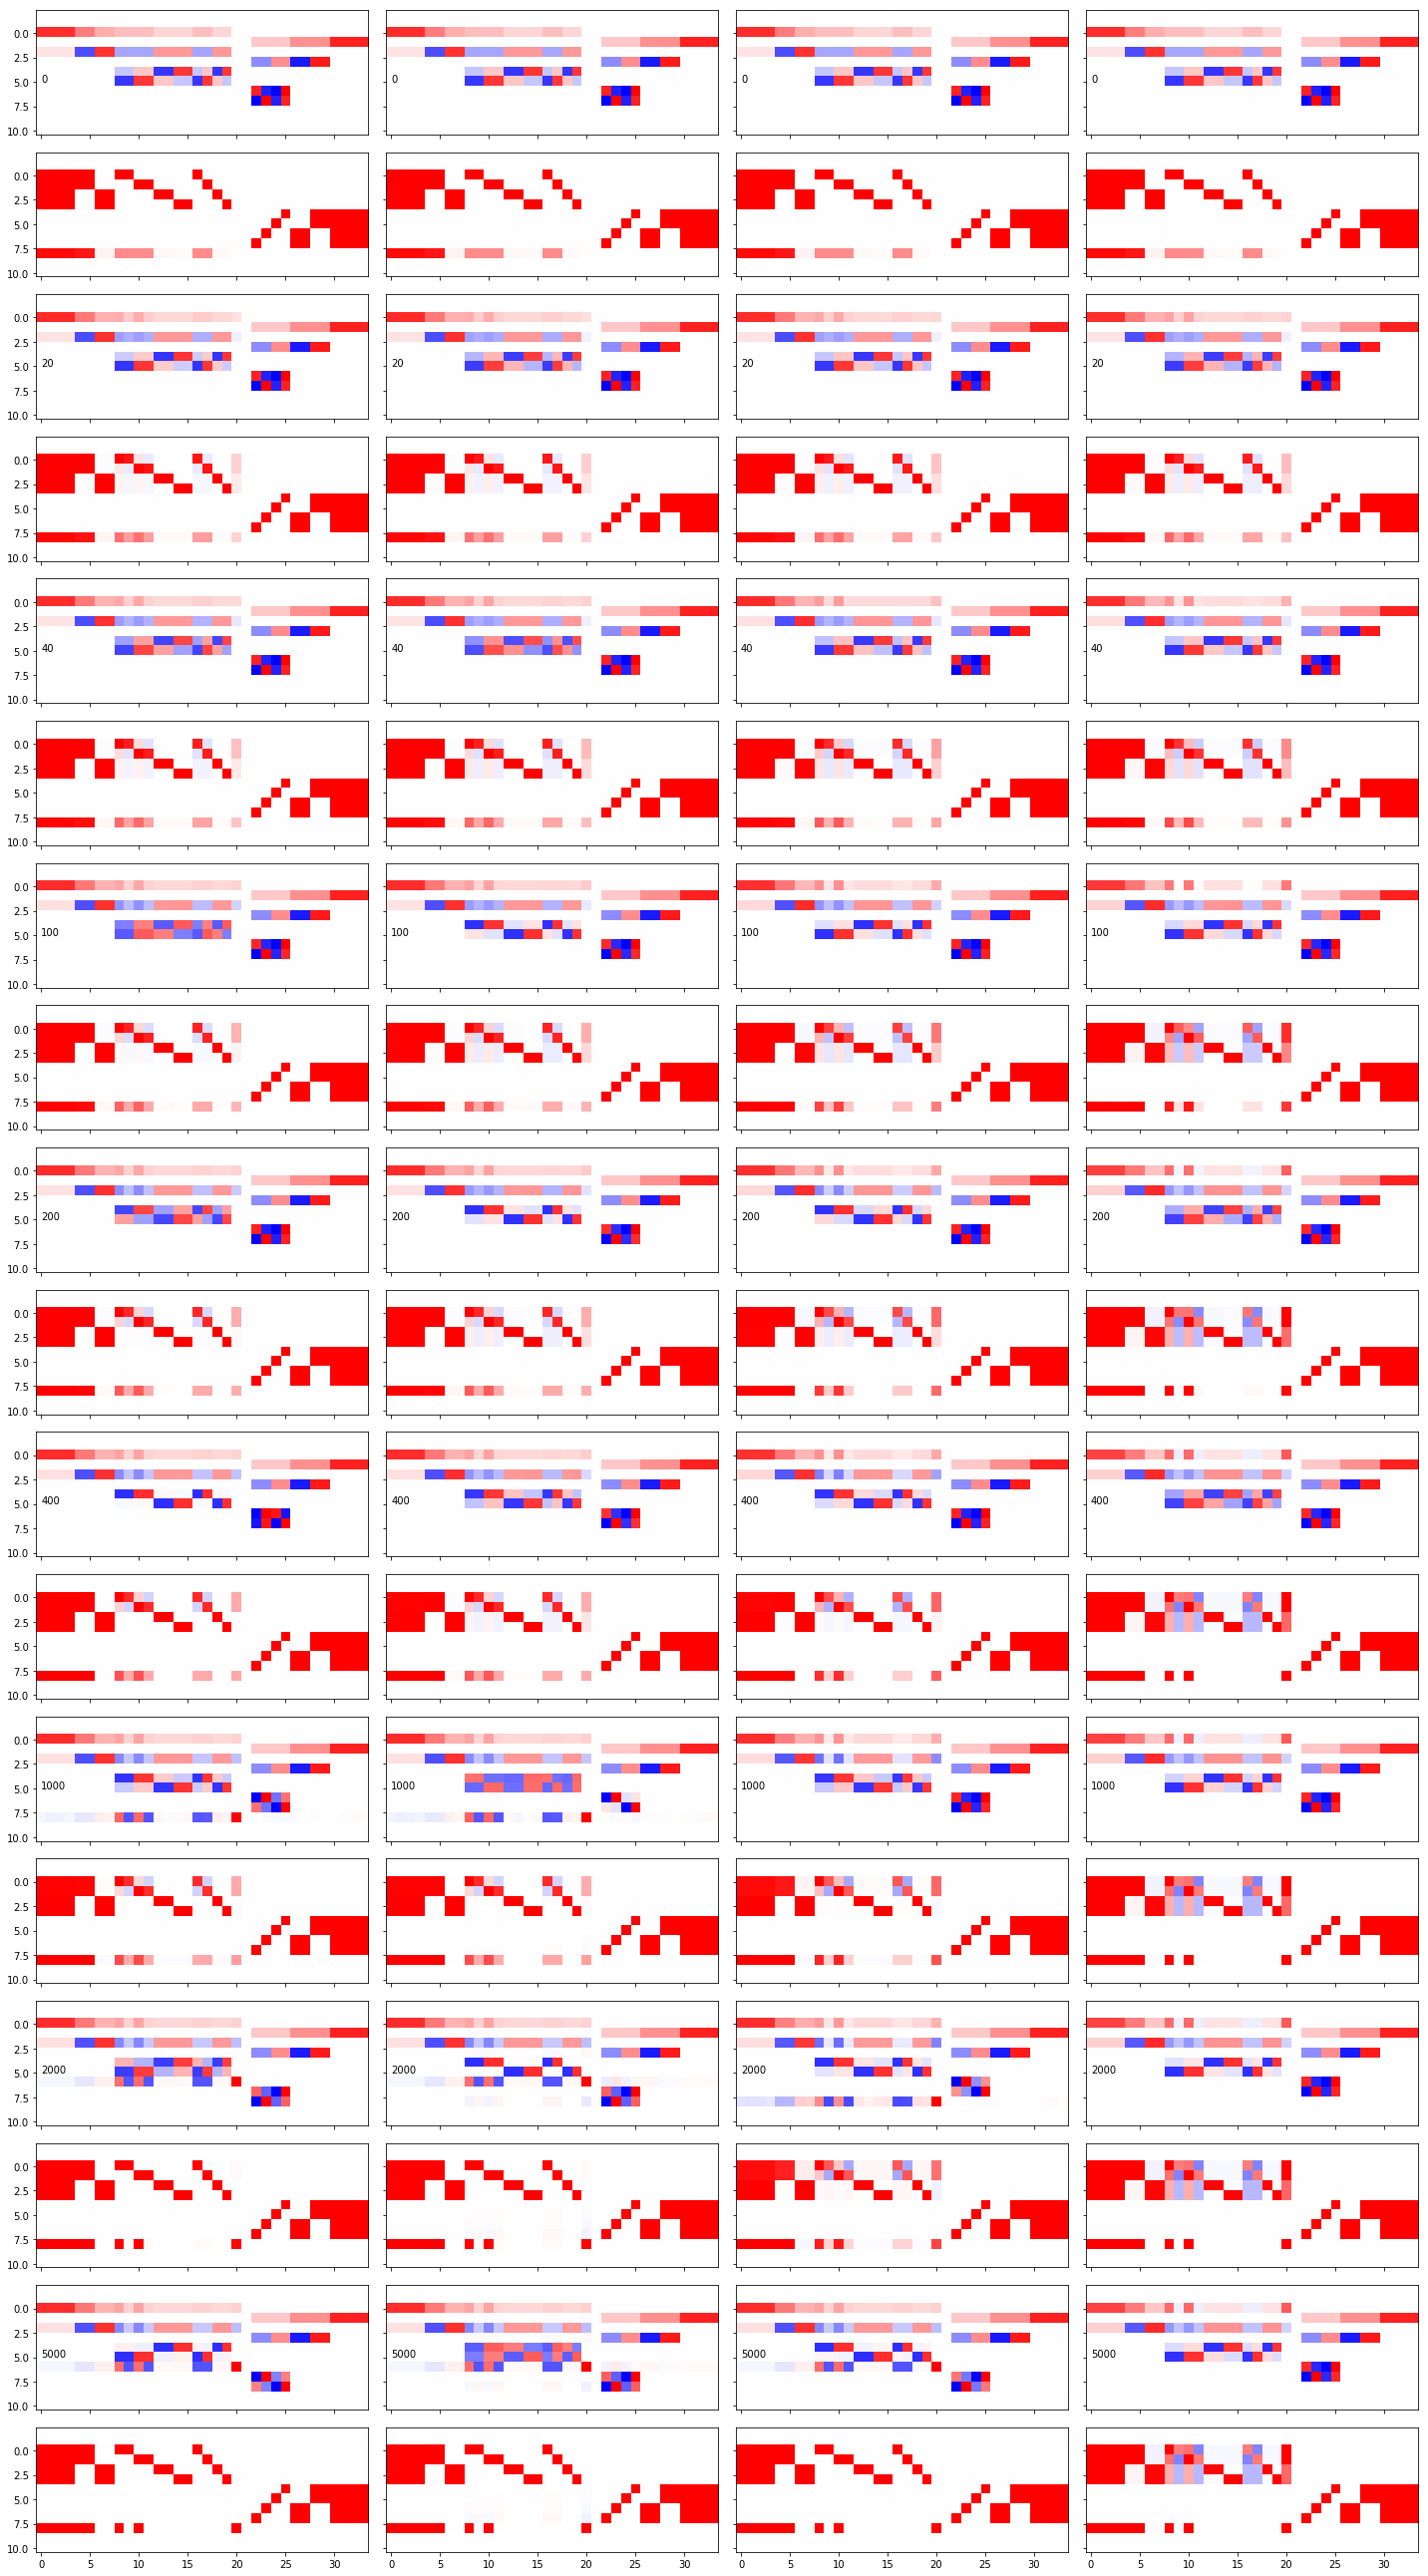

In [10]:
def mkpatplots3():
    steplist = np.array([0,1,2,5, 10, 20, 50, 100, 250])
    sll = len(steplist)
    condlist = np.array([0,1,2,3])
    cll = len(condlist)
    fig, ax = plt.subplots(2*sll,cll,sharex=True, sharey=True,figsize=(20,sll*4))
    fig.tight_layout()
    for i in range(cll):
        #ax[0,i].set_title(cname[condlist[i]])
        ax[0,i].set_title('')
    for c in range(sll):
        stp = steplist[c]
        s = str(stp*testinterval)
        for i in range(cll):
            cond = condlist[i]
            ax[2*c,i].imshow(vvec3[cond,stp,0:9,:],cmap='bwr',vmin=-.5,vmax=.5)
            ax[2*c+1,i].imshow(outvec3[cond,stp,0:9,:],#-AllPlsPng[0:9,:],
                               cmap='bwr',vmin=-1,vmax=1)#YlGnBu
            ax[2*c,i].text(0,5,s)
    #plt.show()
    plt.savefig(fig_prefix + 'patplot3.eps')

if AddSpHk:
    mkpatplots3()

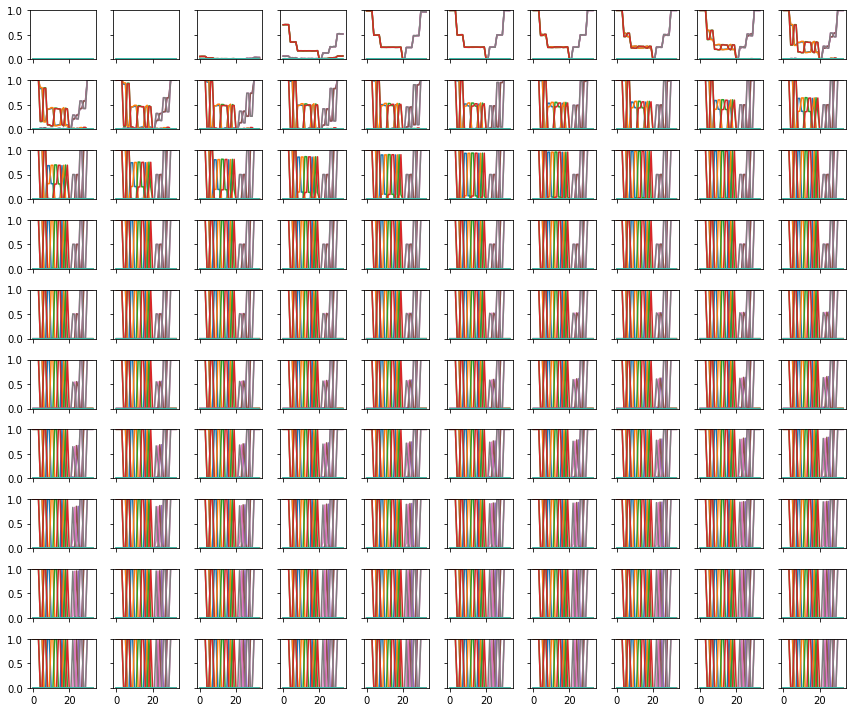

In [11]:
def mkpatplots():
    fig, ax = plt.subplots(10,10,sharex=True, sharey=True,figsize=(12,10))
    fig.tight_layout()
    plt.ylim((0,1))
    for c in range(10):
        for i in range(10):
            ax[c,i].plot(range(vissize),np.transpose(outvec[2*(10*c+i),:,:]))
    #plt.show()
    plt.savefig(fig_prefix + 'patplot.eps')

if AddSpHk:
    mkpatplots()

In [12]:
def mkdimplots():
    fig, ax = plt.subplots(10,10,sharex=True, sharey=True,figsize=(12,10))
    fig.tight_layout()
    for c in range(10):
        for i in range(10):
            ax[c,i].imshow(np.matmul(outvec[2*(10*c+i),:,:],np.transpose(v)),clim=(-2.5,2.5),cmap='bwr')
    plt.show()
   # plt.savefig(fig_prefix + 'dimension_plots.eps')
    
#if AddSpHk:
#    mkdimplots()